In [1]:
import scanpy as sc
import pandas as pd
import bbknn as bbknn

DATA_PATH_23 = 'data/GSE239626/MTX'
DATA_PATH_19 = 'GSE194078'
RANDOM_STATE = 42 

/Users/gabrielebenanti/anaconda3/envs/CHL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cluster_label_adata = sc.read_csv('./results/cluster_labels.csv')
adata_23 = sc.read_10x_mtx(
    DATA_PATH_23,
    var_names='gene_symbols',
    gex_only=True,
    cache=True)
adata_19 = sc.read(DATA_PATH_19)
# Queste sono le etichette di Giulia:
high_label = pd.read_csv('./results/celltypist_labels_Immune_All_High.csv')
low_label = pd.read_csv('./results/celltypist_labels_Immune_All_Low.csv')
# Dopodiche' si deve assegnare  le etichette ai dati 
adata_23.obs['cluster_label'] = cluster_label_adata
adata_23.obs['high_label'] = high_label['predicted_labels'].values
adata_23.obs['low_label'] = low_label['predicted_labels'].values

In [3]:
sc.pp.normalize_total(adata_23, target_sum=1e4)
sc.pp.log1p(adata_23)

In [4]:
sc.pp.normalize_total(adata_19, target_sum=1e4)
sc.pp.log1p(adata_19)

In [5]:
"""sc.pp.pca(adata_23)
sc.pp.neighbors(adata_23)
sc.tl.umap(adata_23)"""

'sc.pp.pca(adata_23)\nsc.pp.neighbors(adata_23)\nsc.tl.umap(adata_23)'

In [6]:
sc.tl.pca(
    adata_23,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )
sc.pp.neighbors(
    adata_23,
    n_neighbors=10,
    n_pcs=5,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    adata_23,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

sc.tl.leiden(
    adata_23,
    resolution=0.5,
    directed=False,
    n_iterations=-1,
    flavor='leidenalg',
    random_state=RANDOM_STATE,
    )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/4b/mr1zrd510kl9vrt3d735hy1m0000gn/T/ipykernel_28312/4179812553.py:23: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


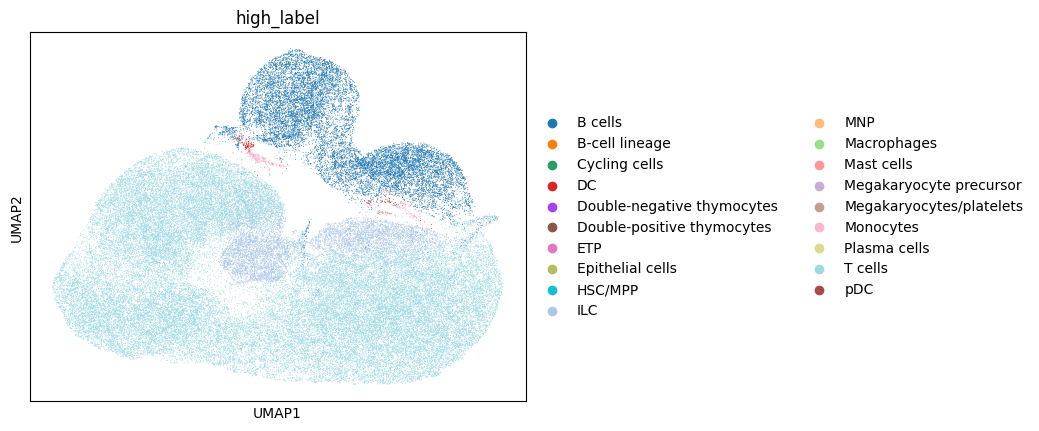

In [7]:
sc.pl.umap(adata_23, color=['high_label'])

In [8]:
adata_19

AnnData object with n_obs × n_vars = 110565 × 36601
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [9]:
adata_23

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'high_label', 'low_label', 'leiden'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'high_label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
sc.tl.ingest(adata_19, adata_23, obs='high_label')

/Users/gabrielebenanti/anaconda3/envs/CHL/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [11]:
#adata_19.obs['high_label'] = adata_23.obs['high_label']  # fix colors

In [12]:
#sc.pl.umap(adata_19, color=['high_label', 'low_label'], wspace=0.5)

In [13]:
adata_concat = adata_23.concatenate(adata_19, batch_categories=['ref', 'new'])

/var/folders/4b/mr1zrd510kl9vrt3d735hy1m0000gn/T/ipykernel_28312/4069995301.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata_23.concatenate(adata_19, batch_categories=['ref', 'new'])


In [14]:
adata_concat.obs.high_label = adata_concat.obs.high_label.astype('category')
adata_concat.obs.high_label.cat.reorder_categories(adata_23.obs.high_label.cat.categories)  # fix category ordering
#adata_concat.obs['high_label'] = adata_23.obs['high_label']  # fix category colors

AAACCCAAGACTGTTC-1-ref         T cells
AAACCCAAGGATCATA-1-ref         T cells
AAACCCAGTTATTCTC-1-ref         B cells
AAACCCATCATGAGGG-1-ref         T cells
AAACGAAAGCCAGTAG-1-ref         B cells
                                ...   
TTTGGTTGTGTTCAGT-11-CSF-new    T cells
TTTGGTTTCAAGAAAC-11-CSF-new    T cells
TTTGTTGGTATACCCA-11-CSF-new    T cells
TTTGTTGGTTATGACC-11-CSF-new        ILC
TTTGTTGTCTCCTGTG-11-CSF-new    T cells
Name: high_label, Length: 182882, dtype: category
Categories (19, object): ['B cells', 'B-cell lineage', 'Cycling cells', 'DC', ..., 'Monocytes', 'Plasma cells', 'T cells', 'pDC']

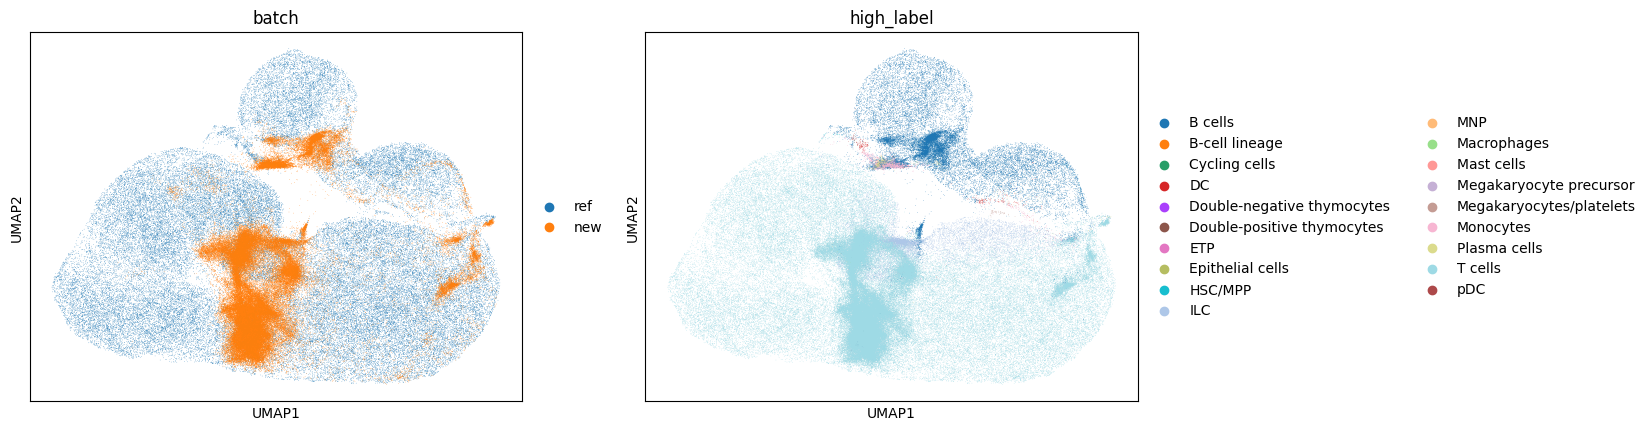

In [15]:
sc.pl.umap(adata_concat, color=['batch', 'high_label'])

In [16]:
sc.tl.pca(adata_concat)

In [17]:
# A questo punto faccio la BBKNN per "allineare i dati"
bbknn.bbknn(adata_concat, batch_key='batch')

/Users/gabrielebenanti/anaconda3/envs/CHL/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/gabrielebenanti/anaconda3/envs/CHL/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited at iteration 827 with accuracies 
[2.84191915e-15 3.07025607e-06 1.60397762e-05 4.65665892e-06]
not reaching the requested tolerance 4.887580871582031e-06.
Use iteration 727 instead with accuracy 
4.064017096581814e-06.

  _, diffusion_map = lobpcg(
/Users/gabrielebenanti/anaconda3/envs/CHL/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited postprocessing with accuracies 
[5.96106218e-15 2.88176660e-06 3.01199429e-06 1.03623075e-05]
not reaching the requested tolerance 4.887580871582031e-06.
  _, diffusion_map = lobpcg(


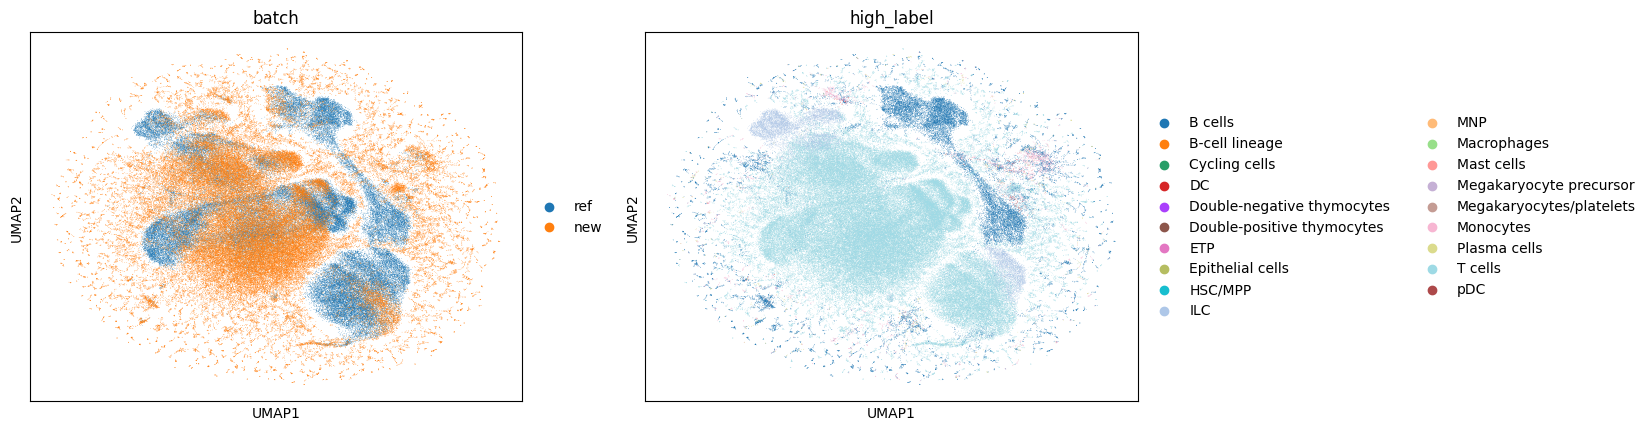

In [18]:
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['batch', 'high_label'])

In [19]:
sc.tl.embedding_density(adata_concat, groupby='batch')

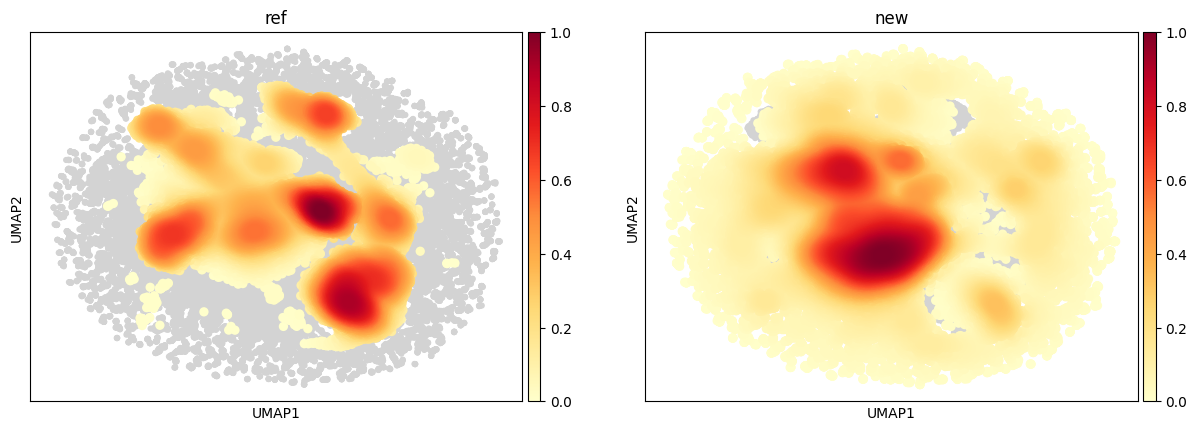

In [20]:
sc.pl.embedding_density(adata_concat, groupby = 'batch')